# High quality intrahost mutations

The aim of this analysis is to assess the impact of different filtering approaches on the CoVigator intrahost mutations dataset and identify a conservative filtering approach that gives us a high quality set of mutations.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from math import pi

sns.set_context("notebook", font_scale=1.25)
sns.color_palette("colorblind")
sns.set(font_scale=2)
sns.set_style("whitegrid")

## References

In [139]:
reference_folder = '../../references/'
data_folder = '../../data/db_dump_20221128/'
figure_output_folder = './filtering_figures'

In [140]:
reference = json.load(open(os.path.join(reference_folder, 'sars_cov_2.json')))

In [141]:
reference.keys()

dict_keys(['genes', 'division', 'species_id', 'dbname', 'reference', 'genebuild', 'GO_genome', 'id', 'organism', 'assembly'])

In [142]:
genes = []
domains = []
for g in reference.get('genes'):
    for p in range(int(g.get('start')), int(g.get('end'))):
        genes.append((g.get('name'), p))
    for f in g.get('transcripts')[0].get('translations')[0].get('protein_features'):
        if f.get('dbname') == 'Pfam':
            for p in range(int(g.get('start')) + int(f.get('start')), int(g.get('start')) + int(f.get('end'))):
                domains.append((f.get('description'), p))
            
genes_df = pd.DataFrame(data=genes, columns=['gene', 'position'])
domains_df = pd.DataFrame(data=domains, columns=['domain', 'position'])

In [143]:
genes_df.head()

,gene,position
0,S,21563
1,S,21564
2,S,21565
3,S,21566
4,S,21567


In [144]:
domains_df.head()

,domain,position
0,CoV_S2,22274
1,CoV_S2,22275
2,CoV_S2,22276
3,CoV_S2,22277
4,CoV_S2,22278


In [145]:
def annotate_variants(variants, annotations):
    return pd.merge(variants, annotations, on='position')

## Data loading

In [146]:
samples = pd.read_csv(os.path.join(data_folder, 'sample_ena.csv.gz'), compression='infer')
samples.head()

,run_accession,finished,sample_accession,scientific_name,study_accession,experiment_accession,first_created,collection_date,instrument_platform,instrument_model,...,percent_duplication,unpaired_reads_examined,read_pairs_examined,secondary_or_supplementary_reads,unmapped_reads,unpaired_read_duplicates,read_pair_duplicates,read_pair_optical_duplicates,covigator_accessor_version,covigator_processor_version
0,ERR5078834,NaN,SAMEA7796020,Severe acute respiratory syndrome coronavirus 2,PRJEB37886,ERX4884988,2021-01-11,2020-09-18,ILLUMINA,unspecified,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,v1.0.0.dev1,v1.1.1
1,ERR9468310,NaN,SAMEA13299001,Severe acute respiratory syndrome coronavirus 2,PRJEB43828,ERX9010135,2022-04-01,2022-02-25,ILLUMINA,Illumina NovaSeq 6000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,v1.0.0.dev1,v1.1.1
2,ERR5885231,NaN,SAMEA8694539,Severe acute respiratory syndrome coronavirus 2,PRJEB44396,ERX5528668,2021-05-06,2021-01-01,ILLUMINA,NextSeq 500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,v1.0.0.dev1,v1.1.1
3,ERR10009744,NaN,SAMEA13793603,Severe acute respiratory syndrome coronavirus 2,PRJEB43828,ERX9550703,2022-07-29,2022-03-14,ILLUMINA,Illumina NovaSeq 6000,...,0.723239,0.0,2016066.0,837.0,24.0,0.0,1458098.0,0.0,v1.0.0.dev1,v1.1.1
4,SRR12768734,NaN,SAMN16361111,Severe acute respiratory syndrome coronavirus 2,PRJNA667180,SRX9239474,2020-10-05,2020-01-01,ILLUMINA,Illumina NovaSeq 6000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,v1.0.0.dev1,v1.1.1


In [147]:
samples.columns

Index(['run_accession', 'finished', 'sample_accession', 'scientific_name',
       'study_accession', 'experiment_accession', 'first_created',
       'collection_date', 'instrument_platform', 'instrument_model',
       'library_name', 'nominal_length', 'library_layout', 'library_strategy',
       'library_source', 'library_selection', 'read_count', 'base_count',
       'sample_collection', 'sequencing_method', 'center_name', 'fastq_ftp',
       'fastq_md5', 'num_fastqs', 'host_tax_id', 'host_sex', 'host_body_site',
       'host_gravidity', 'host_phenotype', 'host_genotype', 'lat', 'lon',
       'country_raw', 'country', 'country_alpha_2', 'country_alpha_3',
       'continent', 'continent_alpha_2', 'count_snvs', 'count_insertions',
       'count_deletions', 'count_subclonal_snvs', 'count_subclonal_insertions',
       'count_subclonal_deletions', 'count_low_frequency_snvs',
       'count_low_frequency_insertions', 'count_low_frequency_deletions',
       'status', 'created_at', 'queued_at'

In [148]:
# filter out unfinished samples
samples = samples[samples.status == 'FINISHED']
samples.shape

(135452, 100)

In [149]:
num_samples = samples.shape[0]

In [150]:
subclonal_variants = pd.read_csv(os.path.join(data_folder, 'subclonal_variant_observation.csv.gz'), compression='infer')
subclonal_variants.head()

,sample,variant_id,chromosome,position,reference,alternate,quality,filter,dp,ac,...,variant_type,length,reference_amino_acid,alternate_amino_acid,position_amino_acid,cons_hmm_sars_cov_2,cons_hmm_sarbecovirus,cons_hmm_vertebrate_cov,pfam_name,pfam_description
0,ERR10322829,10198:C>T,MN908947.3,10198,C,T,272,SUBCLONAL,14,9,...,SNV,0,NaN,NaN,NaN,-0.59191,-0.35633,-0.59191,Peptidase_C30,"Peptidase C30, coronavirus"
1,ERR10322829,21987:G>A,MN908947.3,21987,G,A,17122,SUBCLONAL,850,588,...,SNV,0,G,D,142.0,-1.04511,-1.04511,-0.72927,bCoV_S1_N,"Betacoronavirus-like spike glycoprotein S1, N-..."
2,ERR10322829,22882:T>G,MN908947.3,22882,T,G,14632,SUBCLONAL,805,514,...,SNV,0,N,K,440.0,-1.02973,-1.02973,-0.72927,bCoV_S1_RBD,"Spike receptor binding domain, betacoronavirus"
3,ERR10322829,25000:C>T,MN908947.3,25000,C,T,17590,SUBCLONAL,1122,647,...,SNV,0,NaN,NaN,NaN,-1.27455,-1.27455,0.00000,CoV_S2,"Spike glycoprotein S2, coronavirus"
4,ERR10322829,26577:C>G,MN908947.3,26577,C,G,21709,SUBCLONAL,1168,762,...,SNV,0,Q,E,19.0,0.67226,0.67226,0.00000,CoV_M,"M matrix/glycoprotein, coronavirus"


In [151]:
subclonal_variants.shape

(2510660, 34)

In [152]:
low_frequency_variants = pd.read_csv(os.path.join(data_folder, 'low_frequency_variant_observation.csv.gz'), compression='infer')
low_frequency_variants.head()

,sample,variant_id,chromosome,position,reference,alternate,quality,filter,dp,ac,...,variant_type,length,reference_amino_acid,alternate_amino_acid,position_amino_acid,cons_hmm_sars_cov_2,cons_hmm_sarbecovirus,cons_hmm_vertebrate_cov,pfam_name,pfam_description
0,ERR10322829,40:CT>C,MN908947.3,40,CT,C,55,LOW_FREQUENCY,534,3,...,DELETION,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ERR10322829,509:GGTCATGTTATGGTT>G,MN908947.3,509,GGTCATGTTATGGTT,G,111,LOW_FREQUENCY,1726,7,...,DELETION,-14,NaN,NaN,NaN,0.57215,0.57215,0.00000,bCoV_NSP1,"Non-structural protein NSP1, betacoronavirus"
2,ERR10322829,512:CATGTTATGGTT>C,MN908947.3,512,CATGTTATGGTT,C,59,LOW_FREQUENCY,1743,4,...,DELETION,-11,NaN,NaN,NaN,0.57215,0.57215,0.00000,bCoV_NSP1,"Non-structural protein NSP1, betacoronavirus"
3,ERR10322829,517:TATG>T,MN908947.3,517,TATG,T,77,LOW_FREQUENCY,1766,5,...,DELETION,-3,NaN,NaN,NaN,-0.72927,0.00000,-0.72927,bCoV_NSP1,"Non-structural protein NSP1, betacoronavirus"
4,ERR10322829,518:ATGGTT>A,MN908947.3,518,ATGGTT,A,53,LOW_FREQUENCY,1755,4,...,DELETION,-5,NaN,NaN,NaN,0.00000,0.00000,0.00000,bCoV_NSP1,"Non-structural protein NSP1, betacoronavirus"


In [153]:
low_frequency_variants.shape

(23943046, 34)

In [154]:
variants = pd.concat([low_frequency_variants, subclonal_variants])

In [155]:
variants.columns

Index(['sample', 'variant_id', 'chromosome', 'position', 'reference',
       'alternate', 'quality', 'filter', 'dp', 'ac', 'dp4_ref_forward',
       'dp4_ref_reverse', 'dp4_alt_forward', 'dp4_alt_reverse', 'vaf',
       'strand_bias', 'annotation', 'annotation_impact', 'biotype',
       'annotation_highest_impact', 'gene_name', 'hgvs_c', 'hgvs_p', 'date',
       'variant_type', 'length', 'reference_amino_acid',
       'alternate_amino_acid', 'position_amino_acid', 'cons_hmm_sars_cov_2',
       'cons_hmm_sarbecovirus', 'cons_hmm_vertebrate_cov', 'pfam_name',
       'pfam_description'],
      dtype='object')

In [156]:
variants = annotate_variants(variants=variants, annotations=genes_df)

In [157]:
variants = annotate_variants(variants=variants, annotations=domains_df)

## Evaluate dataset

In [158]:
def calculate_dist(samples, variants):
    # we take into account samples here to make sure the median includes samples with 0 intrahost
    count_per_sample = pd.merge(variants[['sample', 'variant_id']].groupby('sample').count().reset_index(), samples.run_accession, left_on='sample', right_on='run_accession', how='outer').fillna(0).variant_id
    return count_per_sample.median(), count_per_sample.quantile(0.25), count_per_sample.quantile(0.75)

def calculate_median_mutations_per_sample(samples, variants):
    # we take into account samples here to make sure the median includes samples with 0 intrahost
    count_per_sample = pd.merge(variants[['sample', 'variant_id']].groupby('sample').count().reset_index(), samples.run_accession, left_on='sample', right_on='run_accession', how='outer').fillna(0).variant_id
    return count_per_sample.median()

def calculate_inframe_fs_ratio(variants):
    return variants[variants.annotation_highest_impact.isin(['conservative_inframe_deletion', 'disruptive_inframe_deletion', 'conservative_inframe_insertion', 'disruptive_inframe_insertion'])].shape[0] / \
          variants[variants.annotation_highest_impact == 'frameshift_variant'].shape[0]

    
def calculate_ns_s_ratio(variants):
    return variants[variants.annotation_highest_impact.isin(['missense_variant', 'stop_lost', 'stop_gained', 'start_lost'])].shape[0] / variants[variants.annotation_highest_impact == 'synonymous_variant'].shape[0]


def print_results_values(results):
    for v in results.values():
        print(v)

In [159]:
variants.annotation_highest_impact.unique()

array(['frameshift_variant', 'disruptive_inframe_deletion',
       'missense_variant', 'disruptive_inframe_insertion',
       'conservative_inframe_deletion', 'synonymous_variant',
       'conservative_inframe_insertion', 'stop_gained', 'start_lost',
       'stop_lost', 'gene_fusion'], dtype=object)

In [160]:
def evaluate_dataset(samples, variants):
    
    data = {
        'Num. samples': samples.shape[0],
        ###
        'Num. mutations': variants.shape[0],
        'Num. SNVs': variants[variants.variant_type == 'SNV'].shape[0],
        'Num. insertions': variants[variants.variant_type == 'INSERTION'].shape[0],
        'Num. deletions': variants[variants.variant_type == 'DELETION'].shape[0],
        ###
        'Num. unique mutations': variants.variant_id.unique().shape[0],
        'Num. unique SNVs': variants[variants.variant_type == 'SNV'].variant_id.unique().shape[0],
        'Num. unique insertions': variants[variants.variant_type == 'INSERTION'].variant_id.unique().shape[0],
        'Num. unique deletions': variants[variants.variant_type == 'DELETION'].variant_id.unique().shape[0],
        ###
        'Median VAF': variants.vaf.median(),
        'Median AC': variants.ac.median(),
        'Median DP': variants.dp.median(),
        ###
        'Median mutations per sample': calculate_median_mutations_per_sample(samples, variants),
        'Median SNVs per sample': calculate_median_mutations_per_sample(samples, variants[variants.variant_type == 'SNV']),
        'Median insertions per sample': calculate_median_mutations_per_sample(samples, variants[variants.variant_type == 'INSERTION']),
        'Median deletions per sample': calculate_median_mutations_per_sample(samples, variants[variants.variant_type == 'DELETION']),
        ###
        'Ratio of NS/S': round(calculate_ns_s_ratio(variants), 3),
        'Ratio of in-frame/frameshift': round(calculate_inframe_fs_ratio(variants), 3),
        'Start loss': variants[variants.annotation_highest_impact == 'start_lost'].shape[0],
        'Ratio start loss': variants[variants.annotation_highest_impact == 'start_lost'].shape[0] / variants.shape[0],
        'Stop gained': variants[variants.annotation_highest_impact == 'stop_gained'].shape[0],
        'Ratio stop gained': variants[variants.annotation_highest_impact == 'stop_gained'].shape[0] / variants.shape[0],
        'Stop loss': variants[variants.annotation_highest_impact == 'stop_lost'].shape[0],
        'Ratio stop loss': variants[variants.annotation_highest_impact == 'stop_lost'].shape[0] / variants.shape[0],
        ###
        'Variant calling quality': variants.quality.median(),
        'Variant calling quality SNVs': variants[variants.variant_type == 'SNV'].quality.median(),
        'Variant calling quality insertions': variants[variants.variant_type == 'INSERTION'].quality.median(),
        'Variant calling quality deletions': variants[variants.variant_type == 'DELETION'].quality.median(),
        ###
        'Entropy genomic positions': variants.position.transform(lambda p: p * np.log(p)).sum(),
        'Entropy genomic positions SNVs': variants[variants.variant_type == 'SNV'].position.transform(lambda p: p * np.log(p)).sum(),
        'Entropy genomic positions insertions': variants[variants.variant_type == 'INSERTION'].position.transform(lambda p: p * np.log(p)).sum(),
        'Entropy genomic positions deletions': variants[variants.variant_type == 'DELETION'].position.transform(lambda p: p * np.log(p)).sum(),
    }
    
    
    return data

In [161]:
results_raw = evaluate_dataset(samples=samples, variants=variants)
results_raw

{'Num. samples': 135452,
 'Num. mutations': 17805559,
 'Num. SNVs': 8300969,
 'Num. insertions': 3846983,
 'Num. deletions': 5657607,
 'Num. unique mutations': 61594,
 'Num. unique SNVs': 23588,
 'Num. unique insertions': 14743,
 'Num. unique deletions': 23263,
 'Median VAF': 0.0056360699236392975,
 'Median AC': 8.0,
 'Median DP': 1779.0,
 'Median mutations per sample': 84.0,
 'Median SNVs per sample': 24.0,
 'Median insertions per sample': 11.0,
 'Median deletions per sample': 28.0,
 'Ratio of NS/S': 2.536,
 'Ratio of in-frame/frameshift': 0.101,
 'Start loss': 6366,
 'Ratio start loss': 0.0003575287919913101,
 'Stop gained': 336324,
 'Ratio stop gained': 0.018888707734477754,
 'Stop loss': 920,
 'Ratio stop loss': 5.1669256775369985e-05,
 'Variant calling quality': 96.0,
 'Variant calling quality SNVs': 118.0,
 'Variant calling quality insertions': 84.0,
 'Variant calling quality deletions': 79.0,
 'Entropy genomic positions': 951942484473.9773,
 'Entropy genomic positions SNVs': 446

In [162]:
print_results_values(results_raw)

135452
17805559
8300969
3846983
5657607
61594
23588
14743
23263
0.0056360699236392975
8.0
1779.0
84.0
24.0
11.0
28.0
2.536
0.101
6366
0.0003575287919913101
336324
0.018888707734477754
920
5.1669256775369985e-05
96.0
118.0
84.0
79.0
951942484473.9773
446076837696.54645
229529416038.528
276336230738.904


In [163]:
results_covigator = evaluate_dataset(samples=samples, variants=subclonal_variants)
results_covigator

{'Num. samples': 135452,
 'Num. mutations': 2510660,
 'Num. SNVs': 1590157,
 'Num. insertions': 640604,
 'Num. deletions': 279899,
 'Num. unique mutations': 127456,
 'Num. unique SNVs': 78658,
 'Num. unique insertions': 15897,
 'Num. unique deletions': 32901,
 'Median VAF': 0.13924099504947662,
 'Median AC': 3.0,
 'Median DP': 22.0,
 'Median mutations per sample': 5.0,
 'Median SNVs per sample': 3.0,
 'Median insertions per sample': 0.0,
 'Median deletions per sample': 1.0,
 'Ratio of NS/S': 2.512,
 'Ratio of in-frame/frameshift': 0.113,
 'Start loss': 1885,
 'Ratio start loss': 0.0007507985947918077,
 'Stop gained': 45460,
 'Ratio stop gained': 0.018106792636199246,
 'Stop loss': 19335,
 'Ratio stop loss': 0.00770116224419077,
 'Variant calling quality': 69.0,
 'Variant calling quality SNVs': 120.0,
 'Variant calling quality insertions': 66.0,
 'Variant calling quality deletions': 388.0,
 'Entropy genomic positions': 391502469502.3932,
 'Entropy genomic positions SNVs': 249719394786.2

In [164]:
print_results_values(results_covigator)

135452
2510660
1590157
640604
279899
127456
78658
15897
32901
0.13924099504947662
3.0
22.0
5.0
3.0
0.0
1.0
2.512
0.113
1885
0.0007507985947918077
45460
0.018106792636199246
19335
0.00770116224419077
69.0
120.0
66.0
388.0
391502469502.3932
249719394786.27924
94223167684.62859
47559907031.485504


In [165]:
results_naif = evaluate_dataset(samples=samples, variants=subclonal_variants[subclonal_variants.vaf < 0.5])
results_naif

{'Num. samples': 135452,
 'Num. mutations': 2288363,
 'Num. SNVs': 1447734,
 'Num. insertions': 639757,
 'Num. deletions': 200872,
 'Num. unique mutations': 126999,
 'Num. unique SNVs': 78431,
 'Num. unique insertions': 15887,
 'Num. unique deletions': 32681,
 'Median VAF': 0.125,
 'Median AC': 2.0,
 'Median DP': 20.0,
 'Median mutations per sample': 3.0,
 'Median SNVs per sample': 2.0,
 'Median insertions per sample': 0.0,
 'Median deletions per sample': 0.0,
 'Ratio of NS/S': 2.49,
 'Ratio of in-frame/frameshift': 0.025,
 'Start loss': 1871,
 'Ratio start loss': 0.0008176150374743867,
 'Stop gained': 42488,
 'Ratio stop gained': 0.01856698434645203,
 'Stop loss': 18698,
 'Ratio stop loss': 0.008170906451467709,
 'Variant calling quality': 67.0,
 'Variant calling quality SNVs': 89.0,
 'Variant calling quality insertions': 66.0,
 'Variant calling quality deletions': 87.0,
 'Entropy genomic positions': 347700072567.9015,
 'Entropy genomic positions SNVs': 223484414507.16443,
 'Entropy g

In [166]:
print_results_values(results_naif)

135452
2288363
1447734
639757
200872
126999
78431
15887
32681
0.125
2.0
20.0
3.0
2.0
0.0
0.0
2.49
0.025
1871
0.0008176150374743867
42488
0.01856698434645203
18698
0.008170906451467709
67.0
89.0
66.0
87.0
347700072567.9015
223484414507.16443
94030483506.86395
30185174553.87339


In [167]:
def evaluate_dataset_by_gene_domain(variants):
    
    print("-----")
    print("Ratio of NS/S: %s" % (round(calculate_ns_s_ratio(variants), 3)))
    for g in variants.gene.unique():
        print("Ratio of NS/S in gene %s: %s" % (g, round(calculate_ns_s_ratio(variants[variants.gene == g]), 3)))
    for d in variants[variants.gene == 'S'].domain.unique():
        print("Ratio of NS/S in domain %s: %s" % (d, round(calculate_ns_s_ratio(variants[variants.domain == d]), 3)))
    
    print("-----")
    print("Ratio of in-frame/frameshift: %s" % (round(calculate_inframe_fs_ratio(variants), 3)))
    for g in variants.gene.unique():
        print("Ratio of in-frame/frameshift in gene %s: %s" % (g, round(calculate_inframe_fs_ratio(variants[variants.gene == g]), 3)))
    for d in variants[variants.gene == 'S'].domain.unique():
        print("Ratio of in-frame/frameshift in domain %s: %s" % (d, round(calculate_inframe_fs_ratio(variants[variants.domain == d]), 3)))

In [168]:
evaluate_dataset_by_gene_domain(variants)

-----
Ratio of NS/S: 2.536
Ratio of NS/S in gene ORF1ab: 2.512
Ratio of NS/S in gene S: 2.608
Ratio of NS/S in gene E: 3.594
Ratio of NS/S in gene N: 2.466
Ratio of NS/S in gene ORF3a: 1.901
Ratio of NS/S in gene M: 4.815
Ratio of NS/S in gene ORF6: 1.652
Ratio of NS/S in gene ORF7b: 2.353
Ratio of NS/S in gene ORF8: 3.094
Ratio of NS/S in gene ORF7a: 3.419
Ratio of NS/S in domain bCoV_S1_N: 1.572
Ratio of NS/S in domain CoV_S2: 3.195
Ratio of NS/S in domain bCoV_S1_RBD: 4.507
Ratio of NS/S in domain CoV_S1_C: 3.419
-----
Ratio of in-frame/frameshift: 0.101
Ratio of in-frame/frameshift in gene ORF1ab: 0.102
Ratio of in-frame/frameshift in gene S: 0.14
Ratio of in-frame/frameshift in gene E: 0.101
Ratio of in-frame/frameshift in gene N: 0.189
Ratio of in-frame/frameshift in gene ORF3a: 0.033
Ratio of in-frame/frameshift in gene M: 0.027
Ratio of in-frame/frameshift in gene ORF6: 0.025
Ratio of in-frame/frameshift in gene ORF7b: 0.03
Ratio of in-frame/frameshift in gene ORF8: 0.007
Ratio

## Sample filtering

In [169]:
samples[['library_strategy', 'run_accession']].groupby('library_strategy').count()

,run_accession
library_strategy,
Targeted-Capture,14068
WGA,73422
WGS,47962


In [170]:
samples[samples['num_reads'].isna()].shape

(0, 100)

### Filter by number of reads as a proxy for viral load

The best proxy for viral load is PCR Ct, but we don't have that information. As an alternative Valesano and Sapoval used the total number of uniquely mapped reads (thresholds of 50,000 and 20,000 reads respectively). Here we will use the total number of reads which will be less conservative.

In [171]:
samples[['num_reads', 'library_strategy']].groupby('library_strategy').mean()

,num_reads
library_strategy,
Targeted-Capture,221718.321439
WGA,537527.281414
WGS,649825.781410


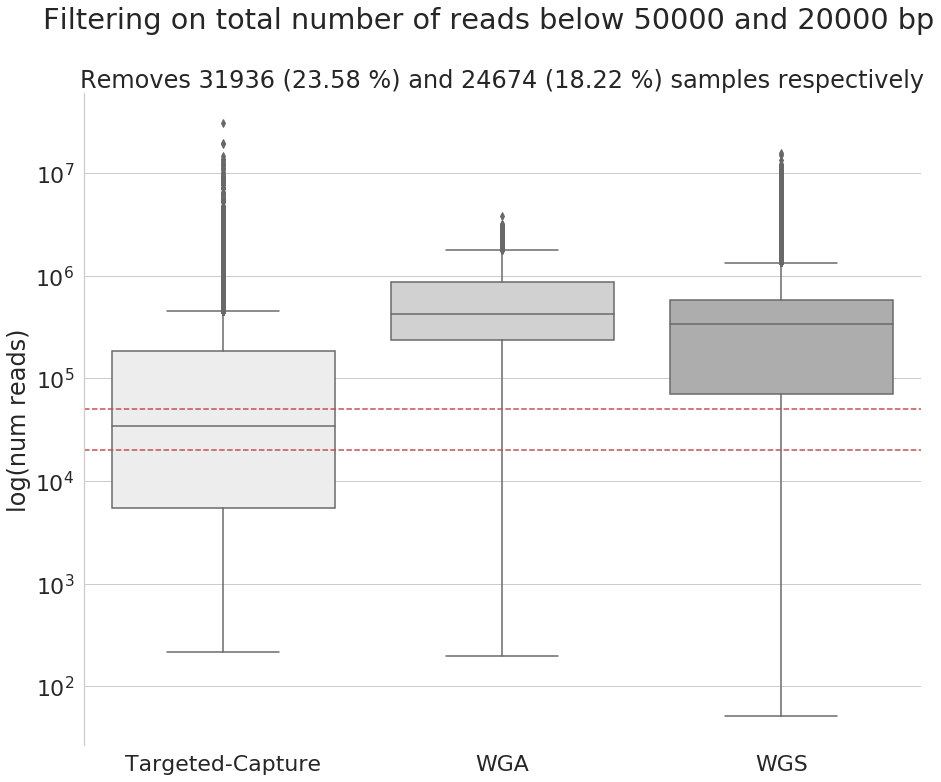

In [172]:
filter_num_reads_1 = 50000
filter_num_reads_2 = 20000

fig = plt.figure(figsize=(15, 12))
sns.boxplot(data=samples, x='library_strategy', y='num_reads', palette=sns.color_palette('Greys'))
plt.yscale('log')
plt.xlabel(None)
plt.ylabel('log(num reads)')
plt.axhline(filter_num_reads_1, c='r', linestyle='--')
plt.axhline(filter_num_reads_2, c='r', linestyle='--')
plt.suptitle("Filtering on total number of reads below {} and {} bp".format(filter_num_reads_1, filter_num_reads_2))
num_filterd_samples_1 = samples[samples.num_reads < filter_num_reads_1].shape[0]
num_filterd_samples_2 = samples[samples.num_reads < filter_num_reads_2].shape[0]
plt.title("Removes {} ({} %) and {} ({} %) samples respectively".format(num_filterd_samples_1, round(float(num_filterd_samples_1) / num_samples * 100, 2), num_filterd_samples_2, round(float(num_filterd_samples_2) / num_samples * 100, 2)))
sns.despine(bottom=True)

fig.savefig(os.path.join(figure_output_folder, 'figure_01_sample_filtering_viral_load.png'), dpi=200)

In [173]:
samples[['library_strategy', 'num_reads']].groupby('library_strategy').median()

,num_reads
library_strategy,
Targeted-Capture,34040.0
WGA,426112.0
WGS,335209.5


### Filter by horizontal coverage

Valesano applies a filter of a consensus sequence of at least 29,000 bp. Popa applies a a filter on 96 % of genome coverage. Others combine horizontal coverage with mean depth of coverage. Here we apply two filters at 29,000 bp covered.

In [174]:
samples[['covered_bases', 'library_strategy']].groupby('library_strategy').mean()

,covered_bases
library_strategy,
Targeted-Capture,29284.447896
WGA,29767.496255
WGS,29525.565844


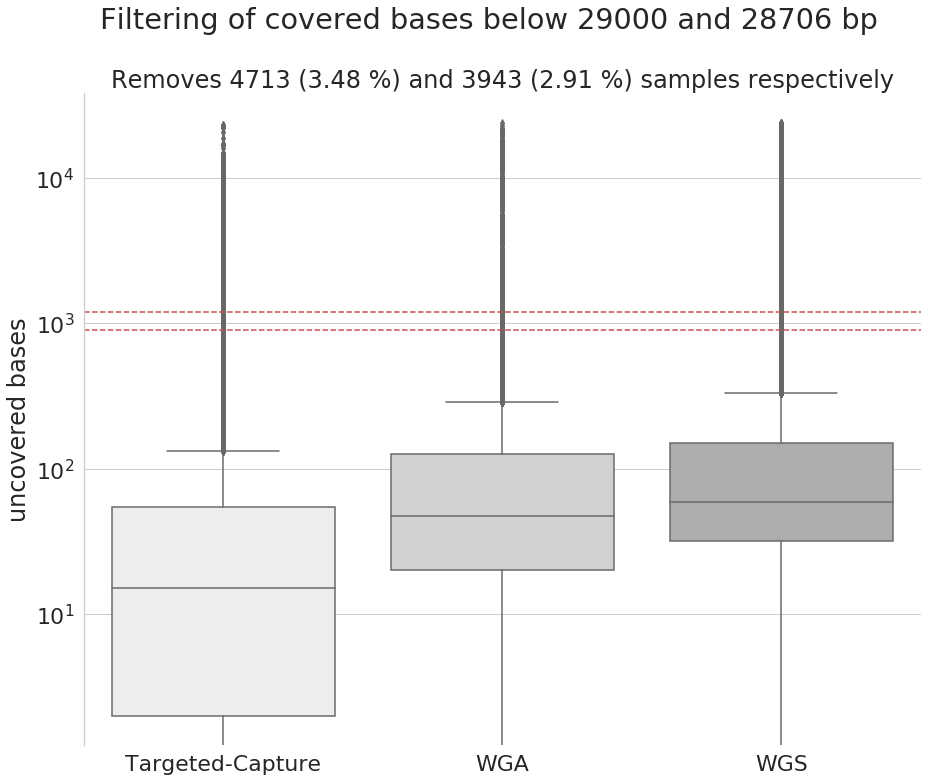

In [175]:
# filter_covered_bases_thr = 29000
total_length = 29903
filter_covered_bases_thr = 29000
filter_covered_bases_thr_2 = int(29903 * 0.96)

fig = plt.figure(figsize=(15, 12))
samples['uncovered_bases'] = samples.covered_bases.transform(lambda c: 29903 - c)
sns.boxplot(data=samples, x='library_strategy', y='uncovered_bases', palette=sns.color_palette('Greys'))
plt.xlabel(None)
plt.yscale('log')
plt.ylabel('uncovered bases')
plt.axhline(29903 - filter_covered_bases_thr, c='r', linestyle='--')
plt.axhline(29903 - filter_covered_bases_thr_2, c='r', linestyle='--')
plt.suptitle("Filtering of covered bases below {} and {} bp".format(filter_covered_bases_thr, filter_covered_bases_thr_2))
num_filterd_samples = samples[samples.covered_bases < filter_covered_bases_thr].shape[0]
num_filterd_samples_2 = samples[samples.covered_bases < filter_covered_bases_thr_2].shape[0]
plt.title("Removes {} ({} %) and {} ({} %) samples respectively".format(num_filterd_samples, round(float(num_filterd_samples) / num_samples * 100, 2), num_filterd_samples_2, round(float(num_filterd_samples_2) / num_samples * 100, 2)))
sns.despine(bottom=True)
fig.savefig(os.path.join(figure_output_folder, 'figure_01_sample_filtering_horizontal_coverage.png'), dpi=200)

In [176]:
samples[['library_strategy', 'coverage']].groupby('library_strategy').median()

,coverage
library_strategy,
Targeted-Capture,99.9498
WGA,99.8428
WGS,99.8027


### Filter by vertical coverage

Wang applies a hard filter on 60x mean coverage. Here we compare the impact of multiple thresholds.

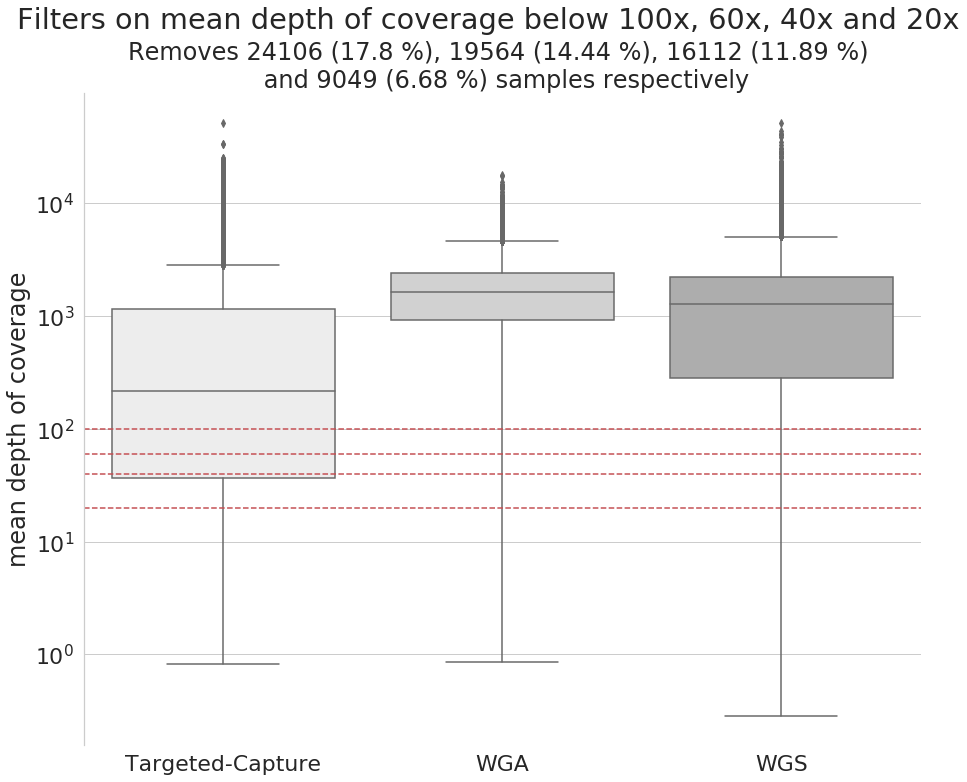

In [177]:
filter_mean_coverage_thr_1 = 100
filter_mean_coverage_thr_2 = 60
filter_mean_coverage_thr_3 = 40
filter_mean_coverage_thr_4 = 20


fig = plt.figure(figsize=(15, 12))
sns.boxplot(data=samples, x='library_strategy', y='mean_depth', palette=sns.color_palette('Greys'))
plt.yscale('log')
plt.xlabel(None)
plt.ylabel('mean depth of coverage')
plt.axhline(filter_mean_coverage_thr_1, c='r', linestyle='--')
plt.axhline(filter_mean_coverage_thr_2, c='r', linestyle='--')
plt.axhline(filter_mean_coverage_thr_3, c='r', linestyle='--')
plt.axhline(filter_mean_coverage_thr_4, c='r', linestyle='--')

plt.suptitle("Filters on mean depth of coverage below 100x, 60x, 40x and 20x")
num_filterd_samples_1 = samples[samples.mean_depth < filter_mean_coverage_thr_1].shape[0]
num_filterd_samples_2 = samples[samples.mean_depth < filter_mean_coverage_thr_2].shape[0]
num_filterd_samples_3 = samples[samples.mean_depth < filter_mean_coverage_thr_3].shape[0]
num_filterd_samples_4 = samples[samples.mean_depth < filter_mean_coverage_thr_4].shape[0]
plt.title("Removes {} ({} %), {} ({} %), {} ({} %) \n and {} ({} %) samples respectively".format(
    num_filterd_samples_1, round(float(num_filterd_samples_1) / num_samples * 100, 2), 
    num_filterd_samples_2, round(float(num_filterd_samples_2) / num_samples * 100, 2), 
    num_filterd_samples_3, round(float(num_filterd_samples_3) / num_samples * 100, 2), 
    num_filterd_samples_4, round(float(num_filterd_samples_4) / num_samples * 100, 2)))
sns.despine(bottom=True)
fig.savefig(os.path.join(figure_output_folder, 'figure_01_sample_filtering_vertical_coverage.png'), dpi=200)

In [178]:
samples[['library_strategy', 'mean_depth']].groupby('library_strategy').median()

,mean_depth
library_strategy,
Targeted-Capture,217.9865
WGA,1626.4850
WGS,1287.7400


### Filter by excess of low frequency variants

In [179]:
data = pd.merge(variants, samples[['run_accession', 'library_strategy']], left_on='sample', right_on='run_accession', how='outer')\
    [['library_strategy', 'run_accession', 'variant_id']]\
    .groupby(['library_strategy', 'run_accession']).count().reset_index()

data_snvs = pd.merge(variants[variants.variant_type == 'SNV'], samples[['run_accession', 'library_strategy']], left_on='sample', right_on='run_accession', how='outer')\
    [['library_strategy', 'run_accession', 'variant_id']]\
    .groupby(['library_strategy', 'run_accession']).count().reset_index()

data_insertion = pd.merge(variants[variants.variant_type == 'INSERTION'], samples[['run_accession', 'library_strategy']], left_on='sample', right_on='run_accession', how='outer')\
    [['library_strategy', 'run_accession', 'variant_id']]\
    .groupby(['library_strategy', 'run_accession']).count().reset_index()

data_deletion = pd.merge(variants[variants.variant_type == 'DELETION'], samples[['run_accession', 'library_strategy']], left_on='sample', right_on='run_accession', how='outer')\
    [['library_strategy', 'run_accession', 'variant_id']]\
    .groupby(['library_strategy', 'run_accession']).count().reset_index()

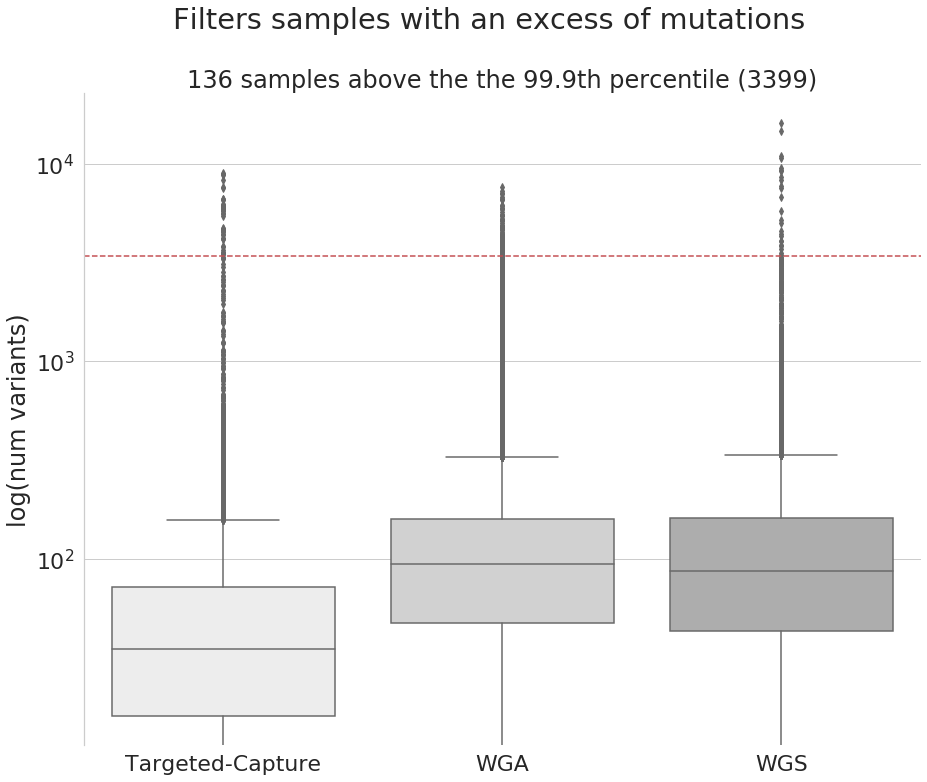

In [180]:
filter_excess_mutations_thr = int(data.variant_id.quantile(0.999))
filter_excess_mutations_thr_snv = data_snvs.variant_id.quantile(0.99)
filter_excess_mutations_thr_ins = data_insertion.variant_id.quantile(0.99)
filter_excess_mutations_thr_dels = data_deletion.variant_id.quantile(0.99)

fig = plt.figure(figsize=(15, 12))
sns.boxplot(data=data, x='library_strategy', y='variant_id', palette=sns.color_palette('Greys'))
plt.yscale('log')
plt.xlabel(None)
plt.ylabel('log(num variants)')
plt.axhline(filter_excess_mutations_thr, c='r', linestyle='--')
#fig.get_axes()[0].get_legend().remove()


plt.suptitle("Filters samples with an excess of mutations")
num_filterd_samples = data[data.variant_id > filter_excess_mutations_thr].shape[0]
plt.title("{} samples above the the 99.9th percentile ({})".format(num_filterd_samples, filter_excess_mutations_thr))
sns.despine(bottom=True)
fig.savefig(os.path.join(figure_output_folder, 'figure_01_sample_excess_mutations.png'), dpi=200)

In [181]:
data.head()

,library_strategy,run_accession,variant_id
0,Targeted-Capture,ERR4192740,50
1,Targeted-Capture,ERR4204119,39
2,Targeted-Capture,ERR4204166,60
3,Targeted-Capture,ERR4204180,113
4,Targeted-Capture,ERR4204203,21


In [182]:
data[['library_strategy', 'variant_id']].groupby('library_strategy').median()

,variant_id
library_strategy,
Targeted-Capture,35
WGA,94
WGS,87


In [183]:
samples[samples.run_accession.isin(data[data.variant_id > filter_excess_mutations_thr].run_accession.unique())][['library_strategy', 'coverage']].groupby('library_strategy').median()

,coverage
library_strategy,
Targeted-Capture,100.0000
WGA,99.8562
WGS,100.0000


In [184]:
samples[samples.run_accession.isin(data[data.variant_id > filter_excess_mutations_thr].run_accession.unique())][['library_strategy', 'num_reads']].groupby('library_strategy').median()

,num_reads
library_strategy,
Targeted-Capture,7976903.5
WGA,306523.0
WGS,1963120.0


In [185]:
samples[samples.run_accession.isin(data[data.variant_id > filter_excess_mutations_thr].run_accession.unique())][['library_strategy', 'run_accession']].groupby('library_strategy').count()

,run_accession
library_strategy,
Targeted-Capture,40
WGA,71
WGS,25


In [186]:
samples[samples.run_accession.isin(data[data.variant_id > filter_excess_mutations_thr].run_accession.unique())][['library_strategy', 'mean_depth']].groupby('library_strategy').median()

,mean_depth
library_strategy,
Targeted-Capture,13631.90
WGA,1256.06
WGS,7755.07


### Identify co-infected samples

In (Tonkin-Hall, 2020) they identify samples co-infected by different SARS-CoV-2 lineages using a linear model to identify those samples' mutations better explained by a combination of two SARS-Cov-2 lineages. 
They aim at filtering out those samples as they contain mutations with iSNV-looking VAFs derived from the co-infection.
Here we use the number of mutations per sample with a VAF between 40 % and 60 % as a proxy for co-infection. We filter out those samples with an outlier number of these mid-VAF mutations.

Furthermore, most of these samples have low horizontal coverage and read count values.

In [187]:
count_variants_per_sample = pd.merge(
    variants[(variants.vaf > 0.4) & (variants.vaf < 0.6)], 
    samples[['run_accession', 'library_strategy']], 
    left_on='sample', right_on='run_accession', how='outer')[['library_strategy', 'run_accession', 'variant_id']]\
.groupby(['library_strategy', 'run_accession']).count().reset_index()

In [188]:
count_variants_per_sample.variant_id.median()

0.0

In [189]:
#outlier_thr = count_variants_per_sample.variant_id.median() + (2 * (count_variants_per_sample.variant_id.quantile(0.75) - count_variants_per_sample.variant_id.quantile(0.25)))
outlier_thr = 10
outlier_thr

10

In [190]:
count_variants_per_sample[count_variants_per_sample.variant_id > outlier_thr].shape[0]

356

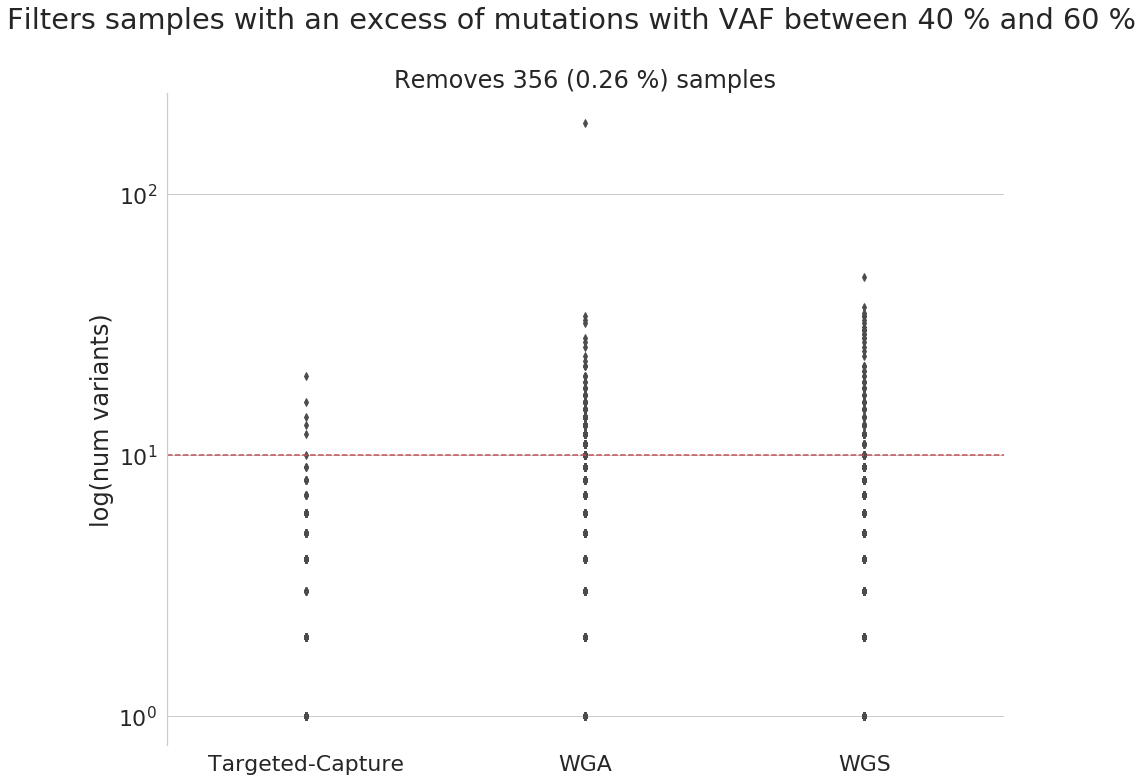

In [191]:
fig = plt.figure(figsize=(15, 12))
sns.boxplot(data=count_variants_per_sample, x='library_strategy', y='variant_id')
plt.yscale('log')
plt.xlabel(None)
plt.ylabel('log(num variants)')
plt.axhline(outlier_thr, c='r', linestyle='--')

plt.suptitle("Filters samples with an excess of mutations with VAF between 40 % and 60 %")
num_filterd_samples = count_variants_per_sample[count_variants_per_sample.variant_id > outlier_thr].shape[0]
plt.title("Removes {} ({} %) samples".format(
    num_filterd_samples, round(float(num_filterd_samples) / num_samples * 100, 2)))
sns.despine(bottom=True)
fig.savefig(os.path.join(figure_output_folder, 'figure_01_sample_filtering_coinfections.png'), dpi=200)

## Filtering variants

In [192]:
total_variants = variants.shape[0]
dp_thrs = [10, 50, 75, 100, 500]
for thr in dp_thrs:
    count_filtered_variants = variants[variants.dp < thr].shape[0]
    print("Filtered {} ({} %) variants with a depth of coverage threshold of {}x".format(count_filtered_variants, round(float(count_filtered_variants) / total_variants * 100, 2), thr))

Filtered 0 (0.0 %) variants with a depth of coverage threshold of 10x
Filtered 969312 (5.44 %) variants with a depth of coverage threshold of 50x
Filtered 1131810 (6.36 %) variants with a depth of coverage threshold of 75x
Filtered 1288727 (7.24 %) variants with a depth of coverage threshold of 100x
Filtered 2513185 (14.11 %) variants with a depth of coverage threshold of 500x


In [193]:
af_thrs = [0.01, 0.02, 0.05]
for thr in af_thrs:
    count_filtered_variants = variants[variants.vaf < thr].shape[0]
    print("Filtered {} ({} %) variants with a VAF threshold of {}".format(count_filtered_variants, round(float(count_filtered_variants) / total_variants * 100, 2), thr))

Filtered 12200227 (68.52 %) variants with a VAF threshold of 0.01
Filtered 14556658 (81.75 %) variants with a VAF threshold of 0.02
Filtered 16170431 (90.82 %) variants with a VAF threshold of 0.05


In [194]:
ac_thrs = [5, 10]
for thr in ac_thrs:
    count_filtered_variants = variants[variants.ac < thr].shape[0]
    print("Filtered {} ({} %) variants with a number of supporting reads threshold of {}".format(count_filtered_variants, round(float(count_filtered_variants) / total_variants * 100, 2), thr))

Filtered 4105799 (23.06 %) variants with a number of supporting reads threshold of 5
Filtered 9842606 (55.28 %) variants with a number of supporting reads threshold of 10


### Variants at the extremes of the genome and at homoplasmic positions

In (Sapoval, 2021) they filter out mutations at the extreme of the genome. In particular mutations between positions 1 and 55 and 29804 and 29903.
They also filter homoplasmic positions previously reported in (De Maio, 2020).

The De Maio list is maintained in this repository, we apply the same filtering with the most up to date resource, to find around a 50 % more variants being masked.

In [195]:
variants[variants.variant_type == 'SNV'][['sample', 'variant_id']].groupby('variant_id').count().reset_index().sort_values(by='sample', ascending=False).head(20)

,variant_id,sample
1417,1730:G>A,89624
9885,2839:T>A,58928
21424,6696:C>T,51906
14853,4229:A>C,48968
12087,330:A>G,45284
1196,1656:T>A,40264
1207,1659:G>T,37252
1169,1647:T>A,36736
1160,1644:A>C,33184
18050,5284:C>T,32976


In [196]:
variants[variants.variant_type == 'INSERTION'][['sample', 'variant_id']].groupby('variant_id').count().reset_index().sort_values(by='sample', ascending=False).head(20)

,variant_id,sample
13470,6696:C>CT,130632
1275,1946:G>GT,61476
41,1026:C>CT,58412
679,1628:C>CA,57016
10464,478:C>CA,54620
1038,1813:T>TA,50072
7910,3448:C>CA,49792
7921,3452:G>GT,48608
7267,3101:C>CA,47116
9667,4376:G>GT,46948


In [197]:
variants[variants.variant_type == 'DELETION'][['sample', 'variant_id']].groupby('variant_id').count().reset_index().sort_values(by='sample', ascending=False).head(20)

,variant_id,sample
17334,509:GGTCATGTTATGGTT>G,201952
17231,507:ATGGTCATGTTATGGT>A,138692
17553,514:TGTTATG>T,128584
17331,509:GGTCATGTTA>G,85460
11095,2889:TG>T,80812
17705,518:ATGGTT>A,78820
21694,685:AAAGTCATTT>A,78332
17650,517:TATG>T,77704
22184,7044:CT>C,53704
14750,4174:TA>T,46676


In [198]:
sapoval_lower_position = 56
sapoval_upper_position = 29803
variants[(variants.position < sapoval_lower_position) | (variants.position > sapoval_upper_position)].shape[0]

0

In [199]:
demaio_homoplasmic_positions = [187, 1059, 2094, 3037, 3130, 6990, 8022, 10323, 10741, 11074, 13408, 14786, 19684, 20148, 21137, 24034, 24378, 25563, 26144, 26461, 26681, 28077, 28826, 28854, 29700]
variants[(variants.position.isin(demaio_homoplasmic_positions))].shape[0]

27962

In [200]:
problematic_sites = pd.read_csv(os.path.join(reference_folder, 'problematic_sites_sarsCov2.mask.decomposed.tsv'), sep='\t', names=['chromosome', 'position', 'reference', 'alternate'])

specific_problematic = problematic_sites[problematic_sites.alternate != '.']
general_problematic = problematic_sites[problematic_sites.alternate == '.']

bases = ['A', 'C', 'G', 'T']
first_pass = general_problematic.copy()
first_pass.alternate = first_pass.reference.transform(lambda r: bases[0] if r not in [bases[0]] else bases[1])

second_pass = general_problematic.copy()
second_pass.alternate = second_pass.reference.transform(lambda r: bases[1] if r not in bases[0:2] else bases[2])

third_pass = general_problematic.copy()
third_pass.alternate = third_pass.reference.transform(lambda r: bases[2] if r not in bases[0:3] else bases[3])


problematic_sites = pd.concat([specific_problematic, first_pass, second_pass, third_pass]).sort_values('position')

problematic_sites['variant_id'] = problematic_sites[['position', 'reference', 'alternate']].apply(lambda x: "{}:{}>{}".format(x[0], x[1], x[2]), axis=1)
problematic_sites['mask'] = True
problematic_sites.head()

,chromosome,position,reference,alternate,variant_id,mask
0,MN908947.3,1,A,T,1:A>T,True
0,MN908947.3,1,A,G,1:A>G,True
0,MN908947.3,1,A,C,1:A>C,True
1,MN908947.3,2,T,G,2:T>G,True
1,MN908947.3,2,T,C,2:T>C,True


In [201]:
masked_variants = pd.merge(variants, problematic_sites[['variant_id', 'mask']], on='variant_id')
masked_variants[masked_variants['mask']].shape[0]

57059

## Valesano-like filtering

In [202]:
valesano_samples = samples[(samples.read_count >= 50000) & (samples.covered_bases >= 29000)]

In [203]:
valesano_variants = variants[(variants['sample'].isin(valesano_samples.run_accession)) &(variants.vaf >= 0.02) & (variants.vaf < 0.5) & (variants.dp >= 100) & (variants.ac >= 10)]

In [204]:
results_valesano = evaluate_dataset(samples=valesano_samples, variants=valesano_variants)
results_valesano

{'Num. samples': 125965,
 'Num. mutations': 1523125,
 'Num. SNVs': 1234647,
 'Num. insertions': 145947,
 'Num. deletions': 142531,
 'Num. unique mutations': 30196,
 'Num. unique SNVs': 20707,
 'Num. unique insertions': 1445,
 'Num. unique deletions': 8044,
 'Median VAF': 0.034862399101257324,
 'Median AC': 45.0,
 'Median DP': 1211.0,
 'Median mutations per sample': 3.0,
 'Median SNVs per sample': 1.0,
 'Median insertions per sample': 0.0,
 'Median deletions per sample': 0.0,
 'Ratio of NS/S': 2.859,
 'Ratio of in-frame/frameshift': 0.109,
 'Start loss': 362,
 'Ratio start loss': 0.000237669265490357,
 'Stop gained': 41170,
 'Ratio stop gained': 0.027029954862535906,
 'Stop loss': 62,
 'Ratio stop loss': 4.0705785802215836e-05,
 'Variant calling quality': 665.0,
 'Variant calling quality SNVs': 594.0,
 'Variant calling quality insertions': 1189.0,
 'Variant calling quality deletions': 896.0,
 'Entropy genomic positions': 84864764908.89848,
 'Entropy genomic positions SNVs': 67578769485.

In [205]:
print_results_values(results_valesano)

125965
1523125
1234647
145947
142531
30196
20707
1445
8044
0.034862399101257324
45.0
1211.0
3.0
1.0
0.0
0.0
2.859
0.109
362
0.000237669265490357
41170
0.027029954862535906
62
4.0705785802215836e-05
665.0
594.0
1189.0
896.0
84864764908.89848
67578769485.19975
9543863748.95212
7742131674.746557


In [206]:
valesano_samples_amplicon = valesano_samples[valesano_samples.library_strategy == "WGA"]

In [207]:
valesano_variants_amplicon = valesano_variants[valesano_variants['sample'].isin(valesano_samples_amplicon.run_accession)]

In [208]:
evaluate_dataset(samples=valesano_samples_amplicon, variants=valesano_variants_amplicon)

{'Num. samples': 72185,
 'Num. mutations': 882571,
 'Num. SNVs': 696226,
 'Num. insertions': 89888,
 'Num. deletions': 96457,
 'Num. unique mutations': 26810,
 'Num. unique SNVs': 18711,
 'Num. unique insertions': 1290,
 'Num. unique deletions': 6809,
 'Median VAF': 0.03496500104665756,
 'Median AC': 45.0,
 'Median DP': 1192.0,
 'Median mutations per sample': 2.0,
 'Median SNVs per sample': 1.0,
 'Median insertions per sample': 0.0,
 'Median deletions per sample': 0.0,
 'Ratio of NS/S': 2.004,
 'Ratio of in-frame/frameshift': 0.091,
 'Start loss': 176,
 'Ratio start loss': 0.00019941738398383813,
 'Stop gained': 15402,
 'Ratio stop gained': 0.017451287205222016,
 'Stop loss': 30,
 'Ratio stop loss': 3.399159954269968e-05,
 'Variant calling quality': 688.0,
 'Variant calling quality SNVs': 621.0,
 'Variant calling quality insertions': 1122.0,
 'Variant calling quality deletions': 824.0,
 'Entropy genomic positions': 52557257016.293655,
 'Entropy genomic positions SNVs': 40760506240.8225

In [209]:
valesano_samples_wgs = valesano_samples[valesano_samples.library_strategy == "WGS"]

In [210]:
valesano_variants_wgs = valesano_variants[valesano_variants['sample'].isin(valesano_samples_wgs.run_accession)]

In [211]:
evaluate_dataset(samples=valesano_samples_wgs, variants=valesano_variants_wgs)

{'Num. samples': 44377,
 'Num. mutations': 579433,
 'Num. SNVs': 497302,
 'Num. insertions': 37850,
 'Num. deletions': 44281,
 'Num. unique mutations': 20640,
 'Num. unique SNVs': 15396,
 'Num. unique insertions': 730,
 'Num. unique deletions': 4514,
 'Median VAF': 0.034246601164340966,
 'Median AC': 46.0,
 'Median DP': 1264.0,
 'Median mutations per sample': 3.0,
 'Median SNVs per sample': 2.0,
 'Median insertions per sample': 0.0,
 'Median deletions per sample': 0.0,
 'Ratio of NS/S': 5.306,
 'Ratio of in-frame/frameshift': 0.178,
 'Start loss': 145,
 'Ratio start loss': 0.0002502446357042143,
 'Stop gained': 24409,
 'Ratio stop gained': 0.042125664226925284,
 'Stop loss': 20,
 'Ratio stop loss': 3.451650147644335e-05,
 'Variant calling quality': 634.0,
 'Variant calling quality SNVs': 570.0,
 'Variant calling quality insertions': 1327.0,
 'Variant calling quality deletions': 1100.0,
 'Entropy genomic positions': 29548556499.2562,
 'Entropy genomic positions SNVs': 24452551648.815224

In [212]:
valesano_samples_targeted = valesano_samples[valesano_samples.library_strategy == "Targeted-Capture"]

In [213]:
valesano_variants_targeted = valesano_variants[valesano_variants['sample'].isin(valesano_samples_targeted.run_accession)]

In [214]:
evaluate_dataset(samples=valesano_samples_targeted, variants=valesano_variants_targeted)

{'Num. samples': 9403,
 'Num. mutations': 61121,
 'Num. SNVs': 41119,
 'Num. insertions': 18209,
 'Num. deletions': 1793,
 'Num. unique mutations': 5280,
 'Num. unique SNVs': 4866,
 'Num. unique insertions': 88,
 'Num. unique deletions': 326,
 'Median VAF': 0.04399999976158142,
 'Median AC': 51.0,
 'Median DP': 1020.0,
 'Median mutations per sample': 4.0,
 'Median SNVs per sample': 0.0,
 'Median insertions per sample': 0.0,
 'Median deletions per sample': 0.0,
 'Ratio of NS/S': 3.418,
 'Ratio of in-frame/frameshift': 0.027,
 'Start loss': 41,
 'Ratio start loss': 0.0006708005431848301,
 'Stop gained': 1359,
 'Ratio stop gained': 0.02223458385824839,
 'Stop loss': 12,
 'Ratio stop loss': 0.00019633186629799905,
 'Variant calling quality': 578.0,
 'Variant calling quality SNVs': 346.0,
 'Variant calling quality insertions': 1477.0,
 'Variant calling quality deletions': 600.0,
 'Entropy genomic positions': 2758951393.3486185,
 'Entropy genomic positions SNVs': 2365711595.562025,
 'Entropy

## Sapoval-like filtering

In [215]:
sapoval_samples = samples[(samples.read_count >= 20000)]

In [216]:
sapoval_variants = variants[(variants['sample'].isin(sapoval_samples.run_accession)) &(variants.vaf >= 0.02) & (variants.vaf < 0.5) & (variants.dp >= 10)]
sapoval_variants = sapoval_variants[~sapoval_variants.position.isin(demaio_homoplasmic_positions)]
sapoval_variants = sapoval_variants[~((sapoval_variants.position < sapoval_lower_position) | (sapoval_variants.position > sapoval_upper_position))]

In [217]:
results_sapoval = evaluate_dataset(samples=sapoval_samples, variants=sapoval_variants)
results_sapoval

{'Num. samples': 131721,
 'Num. mutations': 3074296,
 'Num. SNVs': 2062332,
 'Num. insertions': 587164,
 'Num. deletions': 424800,
 'Num. unique mutations': 40049,
 'Num. unique SNVs': 22635,
 'Num. unique insertions': 4723,
 'Num. unique deletions': 12691,
 'Median VAF': 0.0466667003929615,
 'Median AC': 10.0,
 'Median DP': 261.0,
 'Median mutations per sample': 6.0,
 'Median SNVs per sample': 4.0,
 'Median insertions per sample': 0.0,
 'Median deletions per sample': 0.0,
 'Ratio of NS/S': 2.688,
 'Ratio of in-frame/frameshift': 0.069,
 'Start loss': 643,
 'Ratio start loss': 0.00020915357532261044,
 'Stop gained': 77178,
 'Ratio stop gained': 0.025104284037711398,
 'Stop loss': 165,
 'Ratio stop loss': 5.367082414965898e-05,
 'Variant calling quality': 150.0,
 'Variant calling quality SNVs': 233.0,
 'Variant calling quality insertions': 67.0,
 'Variant calling quality deletions': 81.0,
 'Entropy genomic positions': 168674365074.20615,
 'Entropy genomic positions SNVs': 110828451345.9

In [218]:
print_results_values(results_sapoval)

131721
3074296
2062332
587164
424800
40049
22635
4723
12691
0.0466667003929615
10.0
261.0
6.0
4.0
0.0
0.0
2.688
0.069
643
0.00020915357532261044
77178
0.025104284037711398
165
5.367082414965898e-05
150.0
233.0
67.0
81.0
168674365074.20615
110828451345.95706
34844251794.4593
23001661933.78988


## Tonkin-Hill like filtering

In [219]:
# exclude samples by excess of iSNVs
count_variants_per_sample = pd.merge(variants, samples[['run_accession']], left_on='sample', right_on='run_accession', how='outer')[['run_accession', 'variant_id']].groupby('run_accession').count().reset_index()
excess_mutations_thr = count_variants_per_sample.variant_id.quantile(0.999)
excluded_samples_by_excess_variants = count_variants_per_sample[count_variants_per_sample.variant_id > excess_mutations_thr].run_accession

# exclude samples by excess of high frequency iSNVs, suspicion of co-infection
count_high_variants_per_sample = pd.merge(variants[variants.vaf > 0.4], samples[['run_accession']], left_on='sample', right_on='run_accession', how='outer')[['run_accession', 'variant_id']].groupby('run_accession').count().reset_index()
coinfection_thr = count_high_variants_per_sample.variant_id.median() + (2 * (count_high_variants_per_sample.variant_id.quantile(0.75) - count_high_variants_per_sample.variant_id.quantile(0.25)))
excluded_samples_by_coinfection = count_high_variants_per_sample[count_high_variants_per_sample.variant_id > coinfection_thr].run_accession

tonkin_samples = samples[~(samples.run_accession.isin(excluded_samples_by_excess_variants)) & ~(samples.run_accession.isin(excluded_samples_by_coinfection))]

In [220]:
tonkin_variants = variants[(variants['sample'].isin(tonkin_samples.run_accession)) &(variants.vaf >= 0.05) & (variants.vaf < 0.5) & (variants.dp >= 100) & (variants.ac >= 5)]

In [221]:
results_tonkinhill = evaluate_dataset(samples=tonkin_samples, variants=tonkin_variants)
results_tonkinhill

{'Num. samples': 115843,
 'Num. mutations': 366759,
 'Num. SNVs': 262572,
 'Num. insertions': 65735,
 'Num. deletions': 38452,
 'Num. unique mutations': 19564,
 'Num. unique SNVs': 14513,
 'Num. unique insertions': 778,
 'Num. unique deletions': 4273,
 'Median VAF': 0.07527700066566467,
 'Median AC': 69.0,
 'Median DP': 826.0,
 'Median mutations per sample': 0.0,
 'Median SNVs per sample': 0.0,
 'Median insertions per sample': 0.0,
 'Median deletions per sample': 0.0,
 'Ratio of NS/S': 3.004,
 'Ratio of in-frame/frameshift': 0.093,
 'Start loss': 78,
 'Ratio start loss': 0.00021267371761838155,
 'Stop gained': 9735,
 'Ratio stop gained': 0.026543315910448007,
 'Stop loss': 16,
 'Ratio stop loss': 4.3625377973001344e-05,
 'Variant calling quality': 1293.0,
 'Variant calling quality SNVs': 1071.0,
 'Variant calling quality insertions': 2001.0,
 'Variant calling quality deletions': 1585.0,
 'Entropy genomic positions': 22097675696.997936,
 'Entropy genomic positions SNVs': 15914234404.776

In [222]:
print_results_values(results_tonkinhill)

115843
366759
262572
65735
38452
19564
14513
778
4273
0.07527700066566467
69.0
826.0
0.0
0.0
0.0
0.0
3.004
0.093
78
0.00021267371761838155
9735
0.026543315910448007
16
4.3625377973001344e-05
1293.0
1071.0
2001.0
1585.0
22097675696.997936
15914234404.776896
4167206547.46169
2016234744.7593465


## Conservative filter

Excludes samples:
- Mapped reads >= 50,000
- Horizontal coverage >= 29,000 bp
- Exclude samples above 99th percentile of number of iSNVs
- Exclude samples with an outlier number of iSNVs with VAF > 40% and VAF < 80 %

Exclude variants:
- VAF >= 2%, VAF < 50 %
- DP >= 100
- supporting reads >= 10
- Mask extremes of genome + homoplasmic positions from De Maio, 2020
- indels <= 10 bp

In [223]:
conservative_samples = samples[~(samples.run_accession.isin(excluded_samples_by_excess_variants)) & ~(samples.run_accession.isin(excluded_samples_by_coinfection)) & 
                              (samples.read_count >= 50000) & (samples.covered_bases >= 29000)]

In [224]:
conservative_variants = variants[(variants['sample'].isin(conservative_samples.run_accession)) &(variants.vaf >= 0.02) & (variants.vaf < 0.5) & (variants.dp >= 100) & (variants.ac >= 10)]
#conservative_variants = conservative_variants[~conservative_variants.position.isin(demaio_homoplasmic_positions)]
masked_variants = pd.merge(conservative_variants, problematic_sites[['variant_id', 'mask']], on='variant_id', how='outer')
masked_variants['mask'].fillna(False, inplace=True)
conservative_variants = masked_variants[~masked_variants['mask']]
conservative_variants = conservative_variants[~((conservative_variants.position < sapoval_lower_position) | (conservative_variants.position > sapoval_upper_position))]
conservative_variants = conservative_variants[(conservative_variants.length <= 10) & (conservative_variants.length >= -10)]

In [225]:
results_covigator2 = evaluate_dataset(samples=conservative_samples, variants=conservative_variants)
results_covigator2

{'Num. samples': 107318,
 'Num. mutations': 1138580,
 'Num. SNVs': 889729,
 'Num. insertions': 133824,
 'Num. deletions': 115027,
 'Num. unique mutations': 28490,
 'Num. unique SNVs': 19991,
 'Num. unique insertions': 1370,
 'Num. unique deletions': 7129,
 'Median VAF': 0.03371480107307434,
 'Median AC': 43.0,
 'Median DP': 1211.0,
 'Median mutations per sample': 3.0,
 'Median SNVs per sample': 1.0,
 'Median insertions per sample': 0.0,
 'Median deletions per sample': 0.0,
 'Ratio of NS/S': 3.291,
 'Ratio of in-frame/frameshift': 0.073,
 'Start loss': 294,
 'Ratio start loss': 0.00025821637478262396,
 'Stop gained': 34833,
 'Ratio stop gained': 0.030593370689806602,
 'Stop loss': 43,
 'Ratio stop loss': 3.77663405294314e-05,
 'Variant calling quality': 624.0,
 'Variant calling quality SNVs': 540.0,
 'Variant calling quality insertions': 1188.0,
 'Variant calling quality deletions': 820.0,
 'Entropy genomic positions': 62060935604.48811,
 'Entropy genomic positions SNVs': 46973048470.07

In [226]:
print_results_values(results_covigator2)

107318
1138580
889729
133824
115027
28490
19991
1370
7129
0.03371480107307434
43.0
1211.0
3.0
1.0
0.0
0.0
3.291
0.073
294
0.00025821637478262396
34833
0.030593370689806602
43
3.77663405294314e-05
624.0
540.0
1188.0
820.0
62060935604.48811
46973048470.07955
8682967951.270296
6404919183.138243


In [227]:
evaluate_dataset_by_gene_domain(conservative_variants)

-----
Ratio of NS/S: 3.291
Ratio of NS/S in gene ORF1ab: 3.462
Ratio of NS/S in gene S: 1.835
Ratio of NS/S in gene E: 2.341
Ratio of NS/S in gene N: 2.642
Ratio of NS/S in gene ORF3a: 2.099
Ratio of NS/S in gene M: 4.501
Ratio of NS/S in gene ORF6: 1.603
Ratio of NS/S in gene ORF7b: 2.883
Ratio of NS/S in gene ORF8: 2.66
Ratio of NS/S in gene ORF7a: 3.188
Ratio of NS/S in domain bCoV_S1_N: 0.861
Ratio of NS/S in domain CoV_S2: 4.263
Ratio of NS/S in domain bCoV_S1_RBD: 2.717
Ratio of NS/S in domain CoV_S1_C: 3.227
-----
Ratio of in-frame/frameshift: 0.073
Ratio of in-frame/frameshift in gene ORF1ab: 0.074
Ratio of in-frame/frameshift in gene S: 0.088
Ratio of in-frame/frameshift in gene E: 0.054
Ratio of in-frame/frameshift in gene N: 0.099
Ratio of in-frame/frameshift in gene ORF3a: 0.037
Ratio of in-frame/frameshift in gene M: 0.012
Ratio of in-frame/frameshift in gene ORF6: 0.059
Ratio of in-frame/frameshift in gene ORF7b: 0.028
Ratio of in-frame/frameshift in gene ORF8: 0.046
Rati

In [228]:
conservative_variants.to_csv(os.path.join(data_folder, 'conservative_intrahost_variants.csv.gz'), compression='gzip', index=False)
conservative_samples.to_csv(os.path.join(data_folder, 'conservative_intrahost_samples.csv.gz'), compression='gzip', index=False)

## Plot filtering approaches

In [229]:
results_naif_df = pd.DataFrame.from_dict({k :[v] for k, v in results_naif.items()})
results_naif_df['group'] = 'Naif'
results_valesano_df = pd.DataFrame.from_dict({k :[v] for k, v in results_valesano.items()})
results_valesano_df['group'] = 'Valesano-like'
results_sapoval_df = pd.DataFrame.from_dict({k :[v] for k, v in results_sapoval.items()})
results_sapoval_df['group'] = 'Sapoval-like'
results_tonkinhill_df = pd.DataFrame.from_dict({k :[v] for k, v in results_tonkinhill.items()})
results_tonkinhill_df['group'] = 'Tonkin-Hill-like'
results_covigator2_df = pd.DataFrame.from_dict({k :[v] for k, v in results_covigator2.items()})
results_covigator2_df['group'] = 'CoVigator'

results = pd.concat([results_naif_df, results_valesano_df, results_sapoval_df, results_tonkinhill_df, results_covigator2_df]).reset_index()
results

,index,Num. samples,Num. mutations,Num. SNVs,Num. insertions,Num. deletions,Num. unique mutations,Num. unique SNVs,Num. unique insertions,Num. unique deletions,...,Ratio stop loss,Variant calling quality,Variant calling quality SNVs,Variant calling quality insertions,Variant calling quality deletions,Entropy genomic positions,Entropy genomic positions SNVs,Entropy genomic positions insertions,Entropy genomic positions deletions,group
0,0,135452,2288363,1447734,639757,200872,126999,78431,15887,32681,...,0.008171,67.0,89.0,66.0,87.0,3.477001e+11,2.234844e+11,9.403048e+10,3.018517e+10,Naif
1,0,125965,1523125,1234647,145947,142531,30196,20707,1445,8044,...,0.000041,665.0,594.0,1189.0,896.0,8.486476e+10,6.757877e+10,9.543864e+09,7.742132e+09,Valesano-like
2,0,131721,3074296,2062332,587164,424800,40049,22635,4723,12691,...,0.000054,150.0,233.0,67.0,81.0,1.686744e+11,1.108285e+11,3.484425e+10,2.300166e+10,Sapoval-like
3,0,115843,366759,262572,65735,38452,19564,14513,778,4273,...,0.000044,1293.0,1071.0,2001.0,1585.0,2.209768e+10,1.591423e+10,4.167207e+09,2.016235e+09,Tonkin-Hill-like
4,0,107318,1138580,889729,133824,115027,28490,19991,1370,7129,...,0.000038,624.0,540.0,1188.0,820.0,6.206094e+10,4.697305e+10,8.682968e+09,6.404919e+09,CoVigator


In [230]:
results.columns

Index(['index', 'Num. samples', 'Num. mutations', 'Num. SNVs',
       'Num. insertions', 'Num. deletions', 'Num. unique mutations',
       'Num. unique SNVs', 'Num. unique insertions', 'Num. unique deletions',
       'Median VAF', 'Median AC', 'Median DP', 'Median mutations per sample',
       'Median SNVs per sample', 'Median insertions per sample',
       'Median deletions per sample', 'Ratio of NS/S',
       'Ratio of in-frame/frameshift', 'Start loss', 'Ratio start loss',
       'Stop gained', 'Ratio stop gained', 'Stop loss', 'Ratio stop loss',
       'Variant calling quality', 'Variant calling quality SNVs',
       'Variant calling quality insertions',
       'Variant calling quality deletions', 'Entropy genomic positions',
       'Entropy genomic positions SNVs',
       'Entropy genomic positions insertions',
       'Entropy genomic positions deletions', 'group'],
      dtype='object')

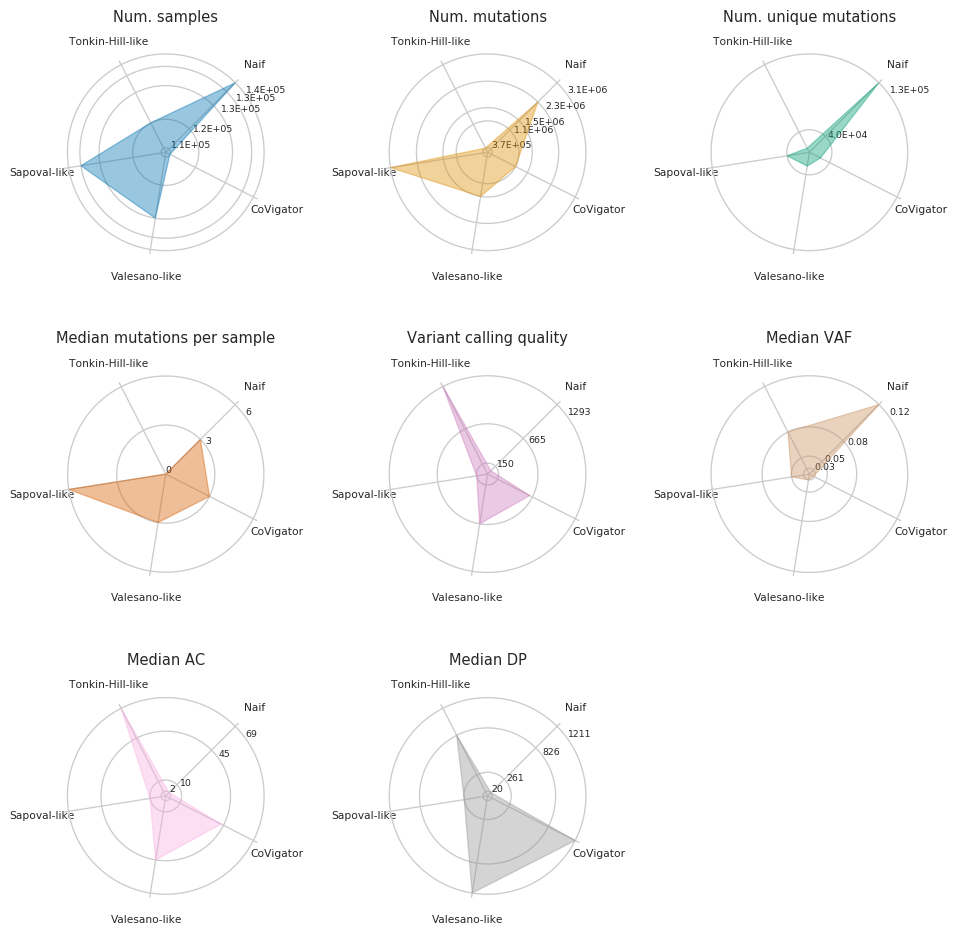

In [258]:
df = results[['group', 'Num. samples', 'Num. mutations', 'Num. unique mutations', 'Median mutations per sample', 'Variant calling quality', 'Median VAF', 'Median AC', 'Median DP']]\
    .set_index('group')\
    .transpose()\
    .reset_index()\
    .rename(columns={'index': 'group'})

df = df[['group', 'Naif', 'CoVigator', 'Valesano-like', 'Sapoval-like', 'Tonkin-Hill-like']]
 
 
def make_spider( row, title, color):

    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(3,3,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 4)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, size=8)
    
    values=df.loc[row].drop('group').values.flatten().tolist()
    values += values[:1]
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    
    max_value = max(values)
    
    sorted_values = sorted(values, reverse=True)
    drop_close_by_values = []
    for i, v in enumerate(sorted_values):
        if i > 0 and sorted_values[i-1] - v < (max(values) - min(values)) * 0.1:
            continue
        else:
            drop_close_by_values.append(v)
        
    
    if max_value > 10000:
        plt.yticks([float(v) / max_value for v in drop_close_by_values], ['%.1E' % v  for v in drop_close_by_values], size=7)
    elif max_value < 1:
        plt.yticks([float(v) / max_value for v in drop_close_by_values], [round(v, 2)  for v in drop_close_by_values], size=7)
    else:
        plt.yticks([float(v) / max_value for v in drop_close_by_values], [int(v) for v in drop_close_by_values], size=7)
    
    ax.fill(angles, values/max(values), color=color, alpha=0.4)
    ax.spines['polar'].set_visible(False)
    pos=ax.get_rlabel_position()
    ax.set_rlabel_position(pos+9)

    # Add a title
    plt.title(title, size=11, y=1.1)
    
    
    
my_dpi=96
fig = plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
for row in range(0, len(df.index)):
    make_spider( row=row, title=df['group'][row], color=sns.color_palette("colorblind")[row])
    
plt.tight_layout()
fig.savefig(os.path.join(figure_output_folder, 'figure_01_filtering_approaches_radar.png'), dpi=200)

In [135]:
df

group,group,Naif,Valesano-like,Sapoval-like,Tonkin-Hill-like,CoVigator
0,Num. samples,135452.000,1.259650e+05,1.317210e+05,115843.000000,1.073180e+05
1,Num. mutations,2288363.000,1.523125e+06,3.074296e+06,366759.000000,1.138580e+06
2,Num. unique mutations,126999.000,3.019600e+04,4.004900e+04,19564.000000,2.849000e+04
3,Median mutations per sample,3.000,3.000000e+00,6.000000e+00,0.000000,3.000000e+00
4,Variant calling quality,67.000,6.650000e+02,1.500000e+02,1293.000000,6.240000e+02
5,Median VAF,0.125,3.486240e-02,4.666670e-02,0.075277,3.371480e-02
6,Median AC,2.000,4.500000e+01,1.000000e+01,69.000000,4.300000e+01
7,Median DP,20.000,1.211000e+03,2.610000e+02,826.000000,1.211000e+03
